In [36]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import datetime
import cartopy
from metpy.units import units

import cartopy.crs as ccrs
import pickle
#import Tracking_Functions

import os

import src.Tracking_Functions as Tracking_Functions
from src.DataLoader import * 
from src.utils import * 
from src.Corrections import * 
from src.Enumerations import Month, Season
from src.xarray_util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
input_path = '/work/aa0238/a271093/results/MOAAP/IVT_Tracking/CNRM_control_test/'
type_='IVT'
input_file_name_temp = 'MOAPP_ICON_control_CNRMforc_100and85controlperc_3dx3dy'

input_field_grid= '/work/aa0238/a271093/data/input/IVT_85_percentiles_CNMR_control_3dx3dy.nc'
first_year = 1984
last_year = 2012
#last_year = 1985
num_years = last_year-first_year

In [38]:
grid_field = xr.open_dataset(input_field_grid, cache = True)


rLon = xr.broadcast(grid_field.rlon, grid_field.rlat)[0].values.T
rLat = xr.broadcast(grid_field.rlon, grid_field.rlat)[1].values.T

regular_Lon = grid_field.lon.values
regular_Lat = grid_field.lat.values

In [39]:
#with open('/work/aa0238/a271093/results/MOAAP/IVT_Tracking/CNRM_control_test/IVT_MOAPP_ICON_control_CNRMforc_100and85controlperc_3dx3dy_1984_01_01-1984_07_01_corrected.pkl', 'rb') as pickle_file:
#    IVT_pkl = pickle.load(pickle_file)
#Lat,Lon=get_coordinates('10', IVT_pkl)
#ak.Array(list(v.values))
#IVTobj_ls.sort(reverse=True,key= lambda x: getattr(x.get,'duration'))
#IVTobj_ls.sortby('duration',reverse=True)
#IVTobj_ls[0].get.duration
#a=IVTobj_ls.sel_season(season=Season.ALL)#.sortby('duration',reverse=True)
#a.sortby('duration',reverse=True)
#with open('/work/aa0238/a271093/results/MOAAP/IVT_Tracking/CNRM_control_test/IVT_MOAPP_ICON_control_CNRMforc_100and85controlperc_3dx3dy_1984_01_01-1984_07_01_corrected.pkl', 'rb') as pickle_file:
#    IVT_pkl = pickle.load(pickle_file)
#IVT_pkl['1']


In [40]:


start_date_list, end_date_list = create_datetime_lists(first_year,last_year, months=6, correct_last_endtime=False) 
#start_date_list_nc, end_date_list_nc = create_datetime_lists(first_year,last_year, months=7, correct_last_endtime=False) 

first_processed_date = start_date_list[0]
last_processed_date = end_date_list[-1]


In [41]:
IVTobj_ls=Object_container([])


for start_date, end_date in zip(start_date_list, end_date_list):
    print(start_date)
    pickle_file_path = f'{input_path}{type_}_{input_file_name_temp}_{get_datetime_str(start_date)}-{get_datetime_str(end_date)}_corrected'
    
    dict_ = get_dict_from_pkl(pickle_file_path)
    

    for object_id in dict_.keys():
        try:
            ds = create_obj_from_dict(dict_,
                                      object_id,
                                      input_path,
                                      input_file_name_temp,
                                      start_date,
                                      end_date,
                                      input_field_grid = input_field_grid,
                                      load_coordinates=False
                                  
                                     )
        except ValueError as ex:
            #print (object_id)
            #print ("start=",dict_[object_id]['times'][0])
            #print ("end=",dict_[object_id]['times'][-1])

            #print(ex)
            continue
        
        IVTobj_ls.append(ds)
    

    

        
    IVTobj_ls.append(ds)
    
    
    

1984-01-01 00:00:00
1984-07-01 00:00:00
1985-01-01 00:00:00
1985-07-01 00:00:00


In [42]:
#%%timeit -r 1 -n 1
#with open(input_path+'xr_container2.pkl','wb') as handle:
#    pickle.dump(IVTobj_ls,handle,protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open(input_path+'xr_container.pkl','rb') as handle:
    dat=pickle.load(handle)

In [ ]:
IVTobj_sel = IVTobj_ls.sel_season(season=Season.SUMMER)


In [ ]:
import awkward as ak
from collections import Counter,namedtuple



def count_objs_grid_points(obj_ls, return_plot_dat = True, normalization_factor =24.):
    grid_point = namedtuple('grid_point',['lat','lon'])
    grid_point_counter= Counter()

    for idx in range(len(obj_ls)):
        obj_lats=obj_ls[idx].rlats
        obj_lons=obj_ls[idx].rlons
        
        points = [grid_point(x,y) for x,y in zip(ak.flatten(ak.Array(list(obj_lats.values))), ak.flatten(ak.Array(list(obj_lons.values))))]
        grid_point_counter.update(points)
        
    if return_plot_dat:
        
        grid_point_ls=list(grid_point_counter.keys())
        z= np.array(list(grid_point_counter.values()))/normalization_factor
        
        lat = np.array([x.lat for x in grid_point_ls])
        lon = np.array([x.lon for x in grid_point_ls])
        
        return lon,lat,z
    
    else:
        return grid_point_counter
        


In [ ]:
#%%timeit -r 1 -n 1




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_irregular_grid(lon,lat, z, index, title=None, cbar_label=None):

    
    
    pole_lon= 0 
    pole_lat=6.55 
    crs_arctic = ccrs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)
       
    ax = fig.add_subplot(4,1, index+1, projection=crs_arctic)


    #ax = plt.axes(projection=crs_arctic)

    ax.set_extent([-180,180, 58, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
    ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0,linewidth=0.5, edgecolor='black')
    ax.gridlines(linewidth=0.5, color='gray',xlocs=range(-180,180,45), ylocs=range(-90,90,10),linestyle=':') #draw_labels=True, 
    ax.coastlines(linewidth=0.3, color='black')

    plot = plt.tricontourf(lon,lat,z,levels=14,cmap="Blues", transform=crs_arctic)
    cbar =plt.colorbar(plot,
                       ax=ax)
    cbar.set_label(cbar_label)
    plt.title(title)
    
    #plt.show()

In [ ]:
fig = plt.figure(figsize=(80,14))

for i, season_ in enumerate(Season):
    print (season_)
    IVTobj_sel = IVTobj_ls.sel_season(season_)

    lon,lat,z = count_objs_grid_points(IVTobj_sel)
    z= z/num_years
    
    plot_irregular_grid(lon,
                        lat, 
                        z, 
                        index = i,
                        title=season_.name,
                        cbar_label = "IVT object days per season")
    
plt.tight_layout()


In [126]:
lon_1D = grid_field.rlon.values
lat_1D = grid_field.rlat.values

In [19]:
for i in Season[0:4]:
    print (i)

KeyError: slice(0, 4, None)

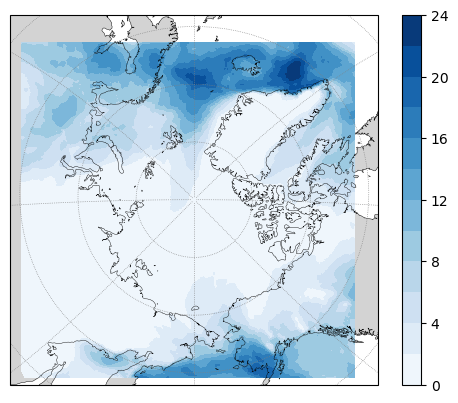

In [135]:
pole_lon= 0 #ds_ivtu.rotated_pole.attrs['grid_north_pole_longitude']
pole_lat=6.55 #ds_ivtu.rotated_pole.attrs['grid_north_pole_latitude']
crs_arctic = ccrs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)

ax = plt.axes(projection=crs_arctic)

ax.set_extent([-180,180, 58, 90], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
ax.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0,linewidth=0.5, edgecolor='black')
ax.gridlines(linewidth=0.5, color='gray',xlocs=range(-180,180,45), ylocs=range(-90,90,10),linestyle=':') #draw_labels=True, 
ax.coastlines(linewidth=0.3, color='black')

plot = plt.tricontourf(lon,lat,z_count,levels=14,cmap="Blues", transform=crs_arctic)
cbar =plt.colorbar(plot,
                   ax=ax)

In [174]:
[grid_point(x,x) for x in rLon]
[grid_point(lat,lon) for lat,lon in zip(rLat.tolist(),rLon.tolist())]
rLat.tolist()

[[-24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.200000762939453,
  -24.20000

In [176]:
pole_lon= 0 #ds_ivtu.rotated_pole.attrs['grid_north_pole_longitude']
pole_lat=6.55 #ds_ivtu.rotated_pole.attrs['grid_north_pole_latitude']
crs_arctic = ccrs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)
#crs_arctic

<Derived Geographic 2D CRS: +proj=ob_tran +ellps=WGS84 +a=6378137.0 +o_proj=la ...>
Name: unnamed
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: PROJ ob_tran o_proj=latlon
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [154]:
fig,ax=plt.subplots(1,1,subplot_kw={'projection': ccrs.Orthographic(0,90)})

tt='2020-04-16T12:00:00.000000000'
ds_out_ar.IVT.sel(time=tt).plot(x='lon',y='lat',vmin=0,vmax=250,ax=ax,cmap='Blues',transform=crs_arctic)
(ds_out_ar.IVT_Objects.sel(time=tt)>0).plot.contour(x='lon',y='lat',levels=1,colors='b',linewidths=2,ax=ax,transform=crs_arctic)
#(ds_out_ar.AR_Objects.sel(time=tt)>0).plot.contour(x='lon',y='lat',levels=1,colors='c',linestyles='--',alpha=0.75,linewidths=2,ax=ax,transform=crs_arctic)

for aa in [ax]:
    aa.set_extent([-180,180, 58, 90], crs=ccrs.PlateCarree())
    aa.add_feature(cartopy.feature.OCEAN, color='white', zorder=0)
    aa.add_feature(cartopy.feature.LAND, color='lightgray',zorder=0,linewidth=0.5, edgecolor='black')
    aa.gridlines(linewidth=0.5, color='gray',xlocs=range(-180,180,45), ylocs=range(-90,90,10),linestyle=':') #draw_labels=True, 
    aa.coastlines(linewidth=0.3, color='black')

In [153]:
#to do
#for loop paralelisieren
#plot triangcontourf

array([[-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       ...,
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7]], dtype=float32)

In [146]:
grid_point_counter
IVTobj_sel = IVTobj_ls.sel_season(season=Season.WINTER)
IVTobj_sel[200]
grid_point_counter.keys()

dict_keys([grid_point(lat=-20.899999618530273, lon=0.699999988079071), grid_point(lat=-20.899999618530273, lon=1.2999999523162842), grid_point(lat=-22.399999618530273, lon=2.5), grid_point(lat=-22.399999618530273, lon=2.799999952316284), grid_point(lat=-22.100000381469727, lon=2.200000047683716), grid_point(lat=-22.100000381469727, lon=2.5), grid_point(lat=-21.799999237060547, lon=1.600000023841858), grid_point(lat=-21.799999237060547, lon=1.899999976158142), grid_point(lat=-21.799999237060547, lon=2.200000047683716), grid_point(lat=-21.799999237060547, lon=2.5), grid_point(lat=-21.5, lon=1.2999999523162842), grid_point(lat=-21.5, lon=1.600000023841858), grid_point(lat=-21.5, lon=1.899999976158142), grid_point(lat=-21.5, lon=2.200000047683716), grid_point(lat=-21.200000762939453, lon=1.0), grid_point(lat=-21.200000762939453, lon=1.2999999523162842), grid_point(lat=-21.200000762939453, lon=1.600000023841858), grid_point(lat=-21.200000762939453, lon=1.899999976158142), grid_point(lat=-21

In [144]:
rLon

array([[-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       ...,
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7],
       [-29.9, -29.6, -29.3, ...,  27.1,  27.4,  27.7]], dtype=float32)

In [100]:
IVTobj_ls[0]

<xarray.Dataset> Size: 2kB
Dimensions:           (times: 12)
Coordinates:
  * times             (times) datetime64[ns] 96B 1984-01-01T23:00:00 ... 1984...
Data variables: (12/14)
    id_               <U1 4B '1'
    nc_file           <U157 628B '/work/aa0238/a271093/results/MOAAP/IVT_Trac...
    size              (times) float64 96B 2.077e+03 2.587e+04 ... 4.206e+03
    total_IVT         (times) float32 48B 202.8 2.684e+03 ... 2.07e+03 404.3
    mean_IVT          (times) float32 48B 101.4 107.4 112.2 ... 103.5 101.1
    max_IVT           (times) float32 48B 101.8 113.1 129.6 ... 111.7 102.4
    ...                ...
    mass_center_rlon  (times) float64 96B 1.0 3.48 3.971 ... 5.235 5.55 5.5
    track_rlat        (times) float64 96B -20.9 -21.5 -21.2 ... -19.1 -18.8
    track_rlon        (times) float64 96B 1.0 1.6 1.9 1.9 ... 2.2 2.2 2.5 2.5
    speed             (times) float64 96B nan 96.14 25.99 ... 44.3 23.87 32.62
    rlats             (times) object 96B [-20.9, -20.9] ... [-19.4, -18.8, -1...
    rlons             (times) object 96B [0.7, 1.3] ... [3.1, 1.9, 2.5, 1.9]

In [81]:
def plot_rotated_pole(lat,lon,plot_dat,title):
    pass

Text(0.5, 1.0, 'Total count of IVT occurrences over entire domain')

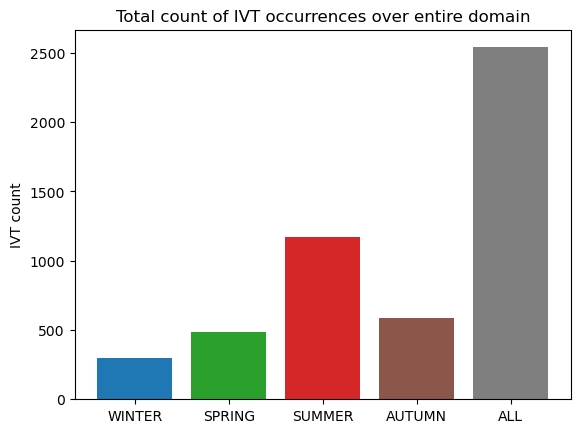

In [91]:
fig, ax = plt.subplots()

seasons = [x.name for x in Season]
bar_labels = ['red', 'blue', '_green', 'brown','ff']
bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:brown','tab:gray']

counts=[]
for season_ in Season:
    counts.append(IVTobj_ls.sel_season(season=season_).count())

    
ax.bar(seasons, counts, color=bar_colors)

ax.set_ylabel('IVT count')
ax.set_title('Total count of IVT occurrences over entire domain')
#plt.grid()
#ax.legend(title='Season')

In [215]:
IVTobj_ls.filter_by_mean(50,'duration',above=False)
getattr(IVTobj_ls[0].get,'duration')#.quantile(0.5)
np.mean(IVTobj_ls.obj_means("duration"))

32.874015748031496

In [232]:
IVTobj_ls.sel_season(season=Season.WINTER).quantile("duration",0.8)

47.400000000000006

18.0


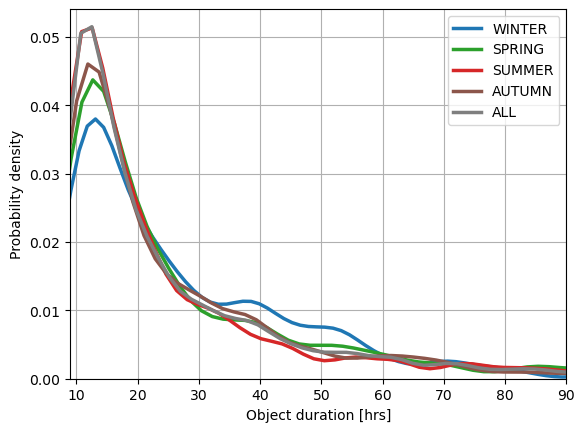

In [233]:
import seaborn as sns
fig, ax = plt.subplots()
bar_labels = ['red', 'blue', '_green', 'brown','ff']
bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:brown','tab:gray']

for i,season_ in enumerate(Season):

    #fig, ax = plt.subplots()

    #dat=IVTobj_ls.sel_season(season=Season.WINTER).get_attributes(attr='duration')##obj_means("size")
    dat=IVTobj_ls.sel_season(season=season_).get_attributes(attr='duration')##obj_means("size")

    sns.kdeplot(dat,label=season_.name,color=bar_colors[i],lw=2.5,bw_adjust=0.3)
    #sns.histplot(dat,label=season_.name,color=bar_colors[i],bins=100, stat='density')

    

ax.set_xlabel('Object duration [hrs]')
ax.set_ylabel('Probability density')
plt.legend()
plt.grid()
ax.set_xlim(9,90)

print (np.quantile(dat,0.5))

NameError: name 'sns' is not defined

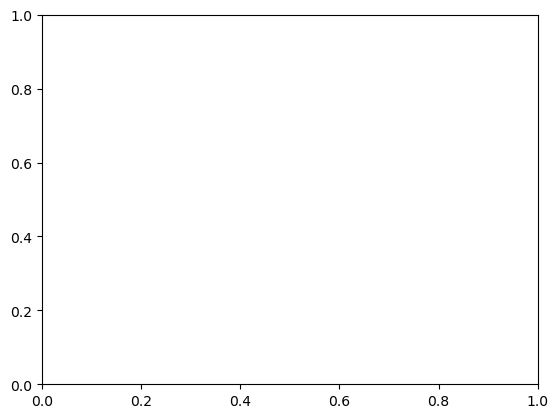

In [217]:
fig, ax = plt.subplots()

for i,season_ in enumerate(Season):

    #fig, ax = plt.subplots()

    dat=IVTobj_ls.sel_season(season=season_).obj_means(attr='size')##obj_means("size")
    sns.kdeplot(dat,label=season_.name,color=bar_colors[i],lw=2.5,bw_adjust=0.1)
   # sns.histplot(dat,label=season_.name,color=bar_colors[i],lw=2.5)
    #sns.histplot(dat,label=season_.name,color=bar_colors[i],bins=100, stat='density')

    

ax.set_xlabel('Object size [km²]')
ax.set_ylabel('probability density')
plt.legend()
plt.grid()
ax.set_xlim(0,150000)


(0.0, 13000.0)

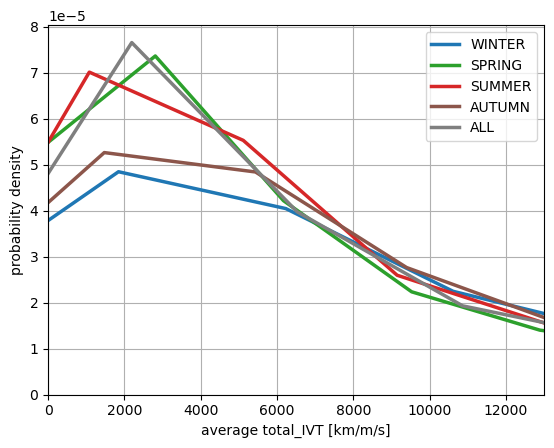

In [56]:
fig, ax = plt.subplots()

for i,season_ in enumerate(Season):

    #fig, ax = plt.subplots()

    dat=IVTobj_ls.sel_season(season=season_).obj_means(attr='total_IVT')##obj_means("size")
    sns.kdeplot(dat,label=season_.name,color=bar_colors[i],lw=2.5,bw_adjust=0.3)
   # sns.histplot(dat,label=season_.name,color=bar_colors[i],lw=2.5)
    #sns.histplot(dat,label=season_.name,color=bar_colors[i],bins=100, stat='density')

    

ax.set_xlabel('average total_IVT [km/m/s]')
ax.set_ylabel('probability density')
plt.legend()
plt.grid()
ax.set_xlim(0,13000)

In [289]:
a=IVTobj_ls.sel_season(season=Season.SUMMER)#.sortby('duration')

In [312]:
a=IVTobj_ls.sel_season(season=Season.SUMMER).sortby('duration',reverse=True)

Text(0.5, 1.0, 'Total count of IVT occurrences over entire domain')

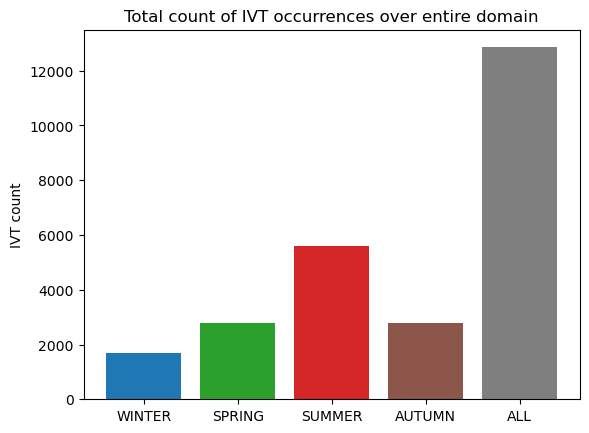

In [59]:
fig, ax = plt.subplots()

seasons = [x.name for x in Season]
bar_labels = ['red', 'blue', '_green', 'brown','ff']
bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:brown','tab:gray']

counts=[]
for season_ in Season:
    counts.append(IVTobj_ls.sel_season(season=season_).count())

    
ax.bar(seasons, counts, color=bar_colors)

ax.set_ylabel('IVT count')
ax.set_title('Total count of IVT occurrences over entire domain')
#plt.grid()
#ax.legend(title='Season')

(9.0, 150.0)

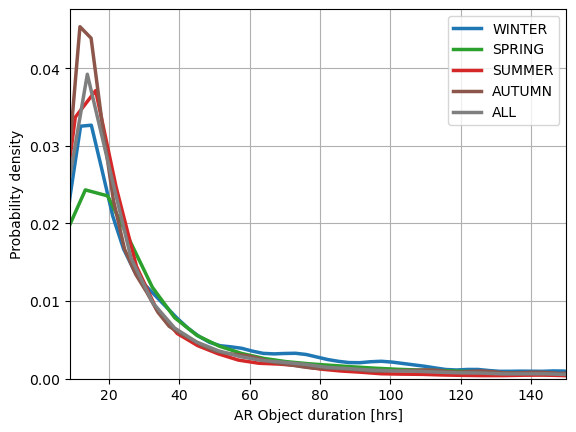

In [71]:
import seaborn as sns
fig, ax = plt.subplots()

for i,season_ in enumerate(Season):

    #fig, ax = plt.subplots()

    dat=IVTobj_ls.sel_season(season=season_).get_attributes(attr='duration')##obj_means("size")
    sns.kdeplot(dat,label=season_.name,color=bar_colors[i],lw=2.5,bw_adjust=0.3)
    #sns.histplot(dat,label=season_.name,color=bar_colors[i],bins=100, stat='density')

    

ax.set_xlabel('AR Object duration [hrs]')
ax.set_ylabel('Probability density')
plt.legend()
plt.grid()
ax.set_xlim(9,150)

(0.0, 150000.0)

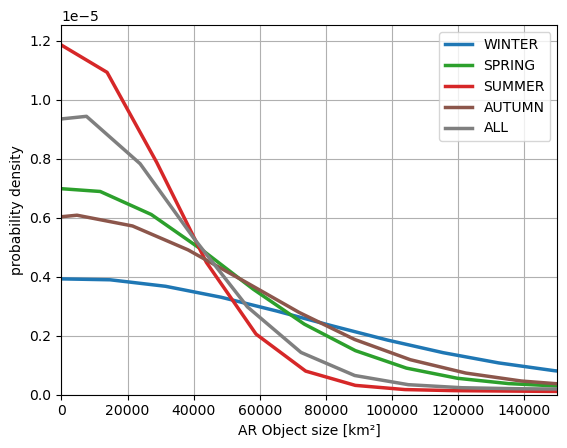

In [65]:
fig, ax = plt.subplots()

for i,season_ in enumerate(Season):

    #fig, ax = plt.subplots()

    dat=IVTobj_ls.sel_season(season=season_).obj_means(attr='size')##obj_means("size")
    sns.kdeplot(dat,label=season_.name,color=bar_colors[i],lw=2.5,bw_adjust=0.3)
   # sns.histplot(dat,label=season_.name,color=bar_colors[i],lw=2.5)
    #sns.histplot(dat,label=season_.name,color=bar_colors[i],bins=100, stat='density')

    

ax.set_xlabel('AR Object size [km²]')
ax.set_ylabel('probability density')
plt.legend()
plt.grid()
ax.set_xlim(0,150000)

(0.0, 23000.0)

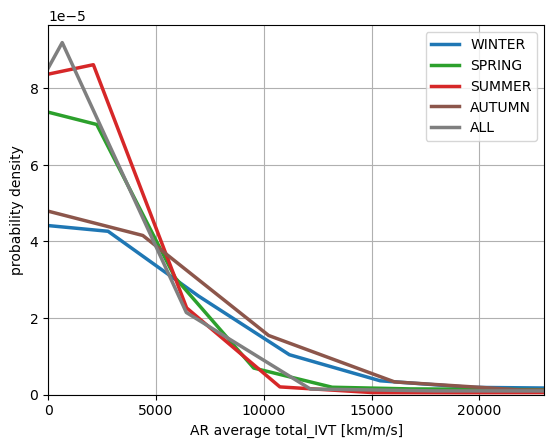

In [72]:
fig, ax = plt.subplots()

for i,season_ in enumerate(Season):

    #fig, ax = plt.subplots()

    dat=IVTobj_ls.sel_season(season=season_).obj_means(attr='total_IVT')##obj_means("size")
    sns.kdeplot(dat,label=season_.name,color=bar_colors[i],lw=2.5,bw_adjust=0.3)
   # sns.histplot(dat,label=season_.name,color=bar_colors[i],lw=2.5)
    #sns.histplot(dat,label=season_.name,color=bar_colors[i],bins=100, stat='density')

    

ax.set_xlabel('AR average total_IVT [km/m/s]')
ax.set_ylabel('probability density')
plt.legend()
plt.grid()
ax.set_xlim(0,23000)